<a href="https://colab.research.google.com/github/autonomi-ai/vlm-cookbook/blob/main/examples/vlm-1-financial-presentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using `vlm-1` to understand financial presentations

In this notebook, we will use the `vlm-1` model to understand financial presentations. The VLM-1 model is a vision-language model trained on a large corpus of financial documents. It is designed to understand the language used in financial documents and can be used to extract information from these documents.

As an example, we will use a dataset from the [SEC Edgar database](https://www.sec.gov/edgar.shtml) that contains financial presentations from various companies. We will use the VLM-1 model to extract information from these presentations and analyze the data.

## 0. Setup

In [ ]:
# Install dependencies if needed
!pip install requests Pillow

## 1. `vlm` API

In this section, we will call the  `vlm-1` API using the Python `requests` library. We will use the `generate` endpoint of the API to extract visual information from the presentation slides.

Let's first test the `health` of the API.

In [4]:
import json
import os
import requests


VLM_BASE_URL = "https://api.vlm.run/v1"
response = requests.get(f"{VLM_BASE_URL}/health")
response.raise_for_status()
assert response.status_code == 200
response.json()

{'status': 'ok'}

## 2. List available models

Now, let's list the available models in the `vlm-1` API. If you are using the API for the first time, you may need to [sign up for an API key](typeform-link).

In [5]:
import getpass

VLM_API_KEY = os.getenv("VLM_API_KEY", None)
if VLM_API_KEY is None:
    VLM_API_KEY = getpass.getpass()
print(f"Using API key: {VLM_API_KEY[:4]}...")

··········
Using API key: sk-s...


In [6]:
headers = {
    "Content-Type": "application/json",
    "X-API-Key": VLM_API_KEY,
}
response = requests.get(f"{VLM_BASE_URL}/models", headers=headers)
response.raise_for_status()

In [7]:
print(json.dumps(response.json(), indent=2))

[
  {
    "model": "vlm-1",
    "domain": "tv.news"
  },
  {
    "model": "vlm-1",
    "domain": "document.presentation"
  },
  {
    "model": "vlm-1",
    "domain": "sports.nfl"
  },
  {
    "model": "vlm-1",
    "domain": "sports.nba"
  },
  {
    "model": "vlm-1",
    "domain": "web.ecommerce-product-catalog"
  }
]


As we can see, there are two models available with the same base model `vlm-1` and different specializated versions (or domain-specific versions), namely `tv.news` and `document.presentation` for TV news and financial presentation understanding, respectively.

## 3. Extract information from financial presentations

First, let's define some helper functions to extract information from the financial presentations.

In [8]:
# %load ../vlm_tools/image.py
import json
from base64 import b64encode
from io import BytesIO
from typing import Literal, Union

import requests
from PIL import Image


def pprint(data):
    print(json.dumps(data, indent=2))


def encode_image(
    image: Image.Image, format: Literal["PNG", "JPEG"] = "PNG"
) -> Union[str, bytes]:
    """Convert an image to a base64 string."""
    buffered = BytesIO()
    image_format = image.format or format
    image.save(buffered, format=image_format)
    img_str = b64encode(buffered.getvalue()).decode()
    return f"data:image/{image_format.lower()};base64,{img_str}"


def download_image(url: str) -> Image.Image:
    """Download an image from a URL."""
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:106.0) Gecko/20100101 Firefox/106.0",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
    }
    bytes = BytesIO(requests.get(url, headers=headers).content)
    bytes.seek(0)
    return Image.open(bytes).convert("RGB")


Finally, let's put together some helper functions to call the VLM API.

In [9]:
from pathlib import Path
from typing import Union

from PIL import Image
from IPython.display import display


def vlm(image: Image.Image, domain: str):
    """Send an image to the VLM API."""
    assert domain in ("tv.news", "document.presentation")
    data = {
        "model": "vlm-1",
        "domain": domain,
        "image": encode_image(image),
    }
    response = requests.post(f"{VLM_BASE_URL}/generate", headers=headers, json=data)
    response.raise_for_status()
    return response.json()


def vlm_visualize(image: Union[Image.Image, str, Path], domain: str):
    """Send an image to the VLM API and display the result."""
    if isinstance(image, str) and image.startswith("http"):
        image = download_image(image)
    elif isinstance(image, (str, Path)):
        if not Path(image).exists():
            raise FileNotFoundError(f"File not found {image}")
        image = Image.open(str(image)).convert("RGB")
    elif isinstance(image, Image.Image):
        image = image.convert("RGB")
    else:
        raise ValueError("Invalid image, must be a path, PIL Image or URL")

    display(image)
    result = vlm(image, domain)
    pprint(result["response"])

Now, let's extract some information from a financial presentation on [SEC EDGAR](https://www.sec.gov/edgar/search-and-access).

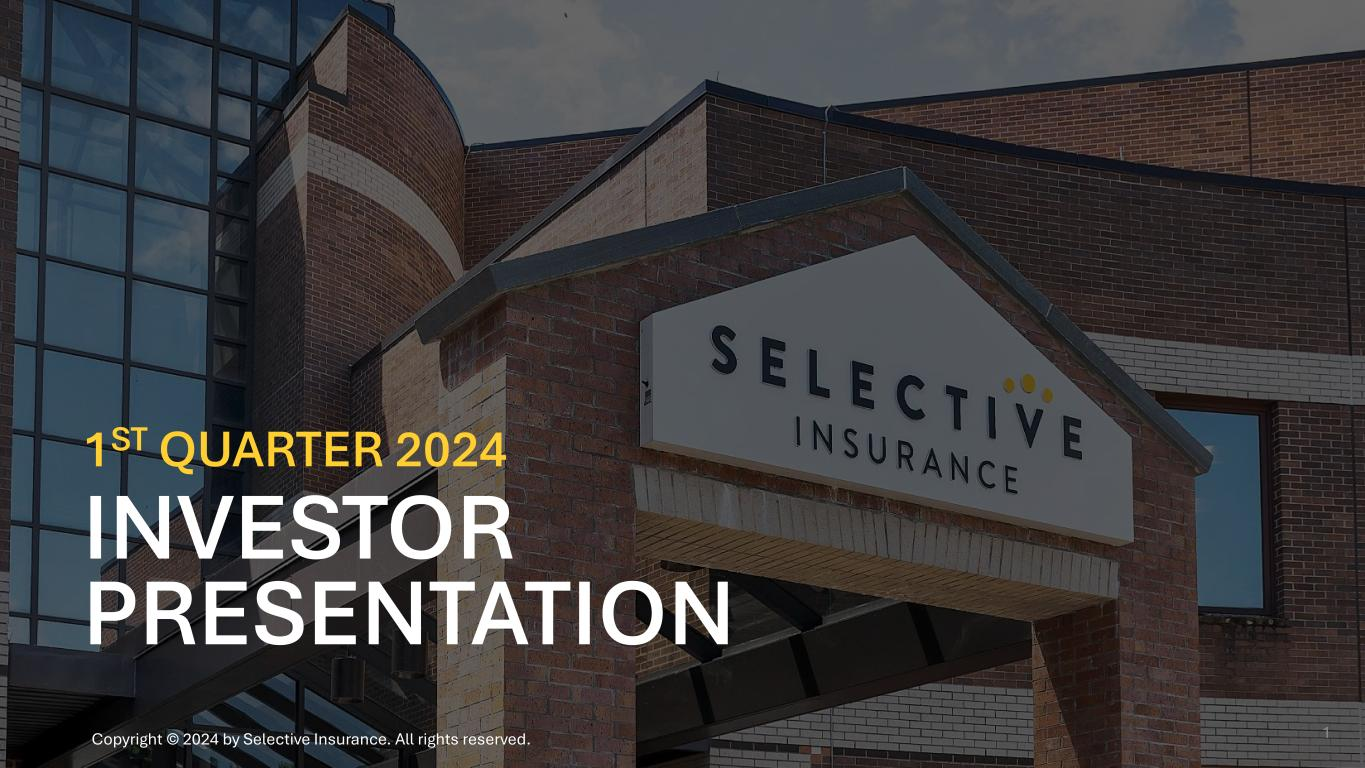

{
  "title": "1st Quarter 2024 Investor Presentation",
  "description": "The image shows the front of a building with a sign that reads 'Selective Insurance'. The building features a modern design with large glass windows and a brick facade. The image is labeled as part of the 1st Quarter 2024 Investor Presentation for Selective Insurance.",
  "page_number": null,
  "plots": null,
  "tables": null,
  "quotes": null,
  "others": [
    {
      "markdown": "![Selective Insurance Building](image_url) The building shown is modern with large glass windows and a brick facade, prominently featuring the 'Selective Insurance' sign.",
      "caption": "Front view of Selective Insurance building.",
      "title": "Selective Insurance Building"
    }
  ]
}


In [10]:
url = "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve001.jpg"
vlm_visualize(url, domain="document.presentation")

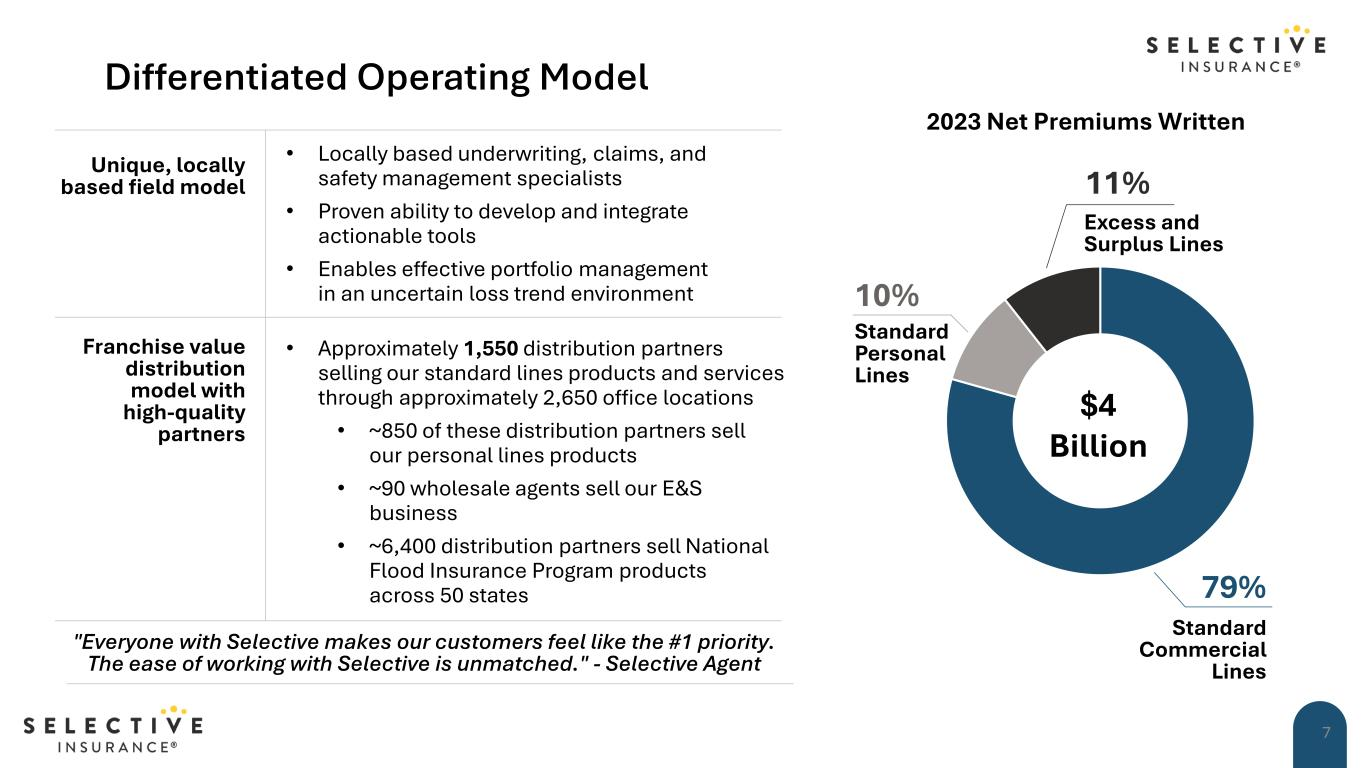

{
  "title": "Differentiated Operating Model",
  "description": "This document page presents the operating model of Selective Insurance, highlighting its unique, locally based field model and franchise value distribution model with high-quality partners. It also includes a pie chart showing the 2023 net premiums written, totaling $4 billion, distributed across different lines of insurance.",
  "page_number": 7,
  "plots": [
    {
      "type": "pie",
      "title": "2023 Net Premiums Written",
      "description": "The pie chart displays the distribution of net premiums written in 2023 totaling $4 billion. It shows that 79% of the premiums are from Standard Commercial Lines, 10% from Standard Personal Lines, and 11% from Excess and Surplus Lines.",
      "markdown": "| Category                | Percentage |\n|-------------------------|------------|\n| Standard Commercial Lines | 79%       |\n| Standard Personal Lines  | 10%       |\n| Excess and Surplus Lines | 11%       |",
      "cap

In [11]:
url = "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve007.jpg"
vlm_visualize(url, domain="document.presentation")

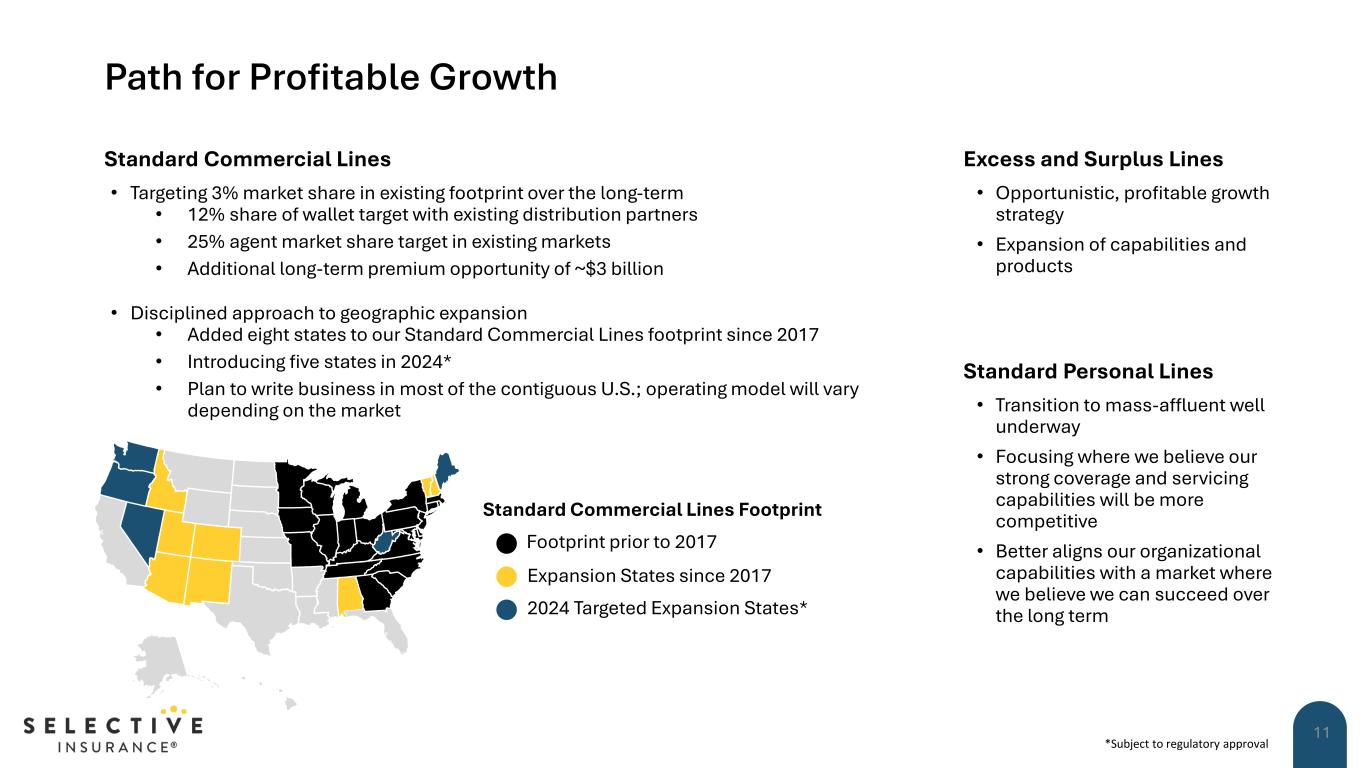

{
  "title": "Path for Profitable Growth",
  "description": "The image presents a strategic overview for profitable growth in various commercial and personal lines of insurance. It includes market share targets, geographic expansion plans, and strategic focuses for different lines of insurance.",
  "page_number": 11,
  "plots": null,
  "tables": null,
  "quotes": null,
  "others": [
    {
      "markdown": "### Standard Commercial Lines\n- Targeting 3% market share in existing footprint over the long-term\n  - 12% share of wallet target with existing distribution partners\n  - 25% agent market share target in existing markets\n  - Additional long-term premium opportunity of ~$3 billion\n- Disciplined approach to geographic expansion\n  - Added eight states to our Standard Commercial Lines footprint since 2017\n  - Introducing five states in 2024*\n  - Plan to write business in most of the contiguous U.S.; operating model will vary depending on the market\n\n### Excess and Surplus Lines

In [12]:
url = "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve011.jpg"
vlm_visualize(url, domain="document.presentation")

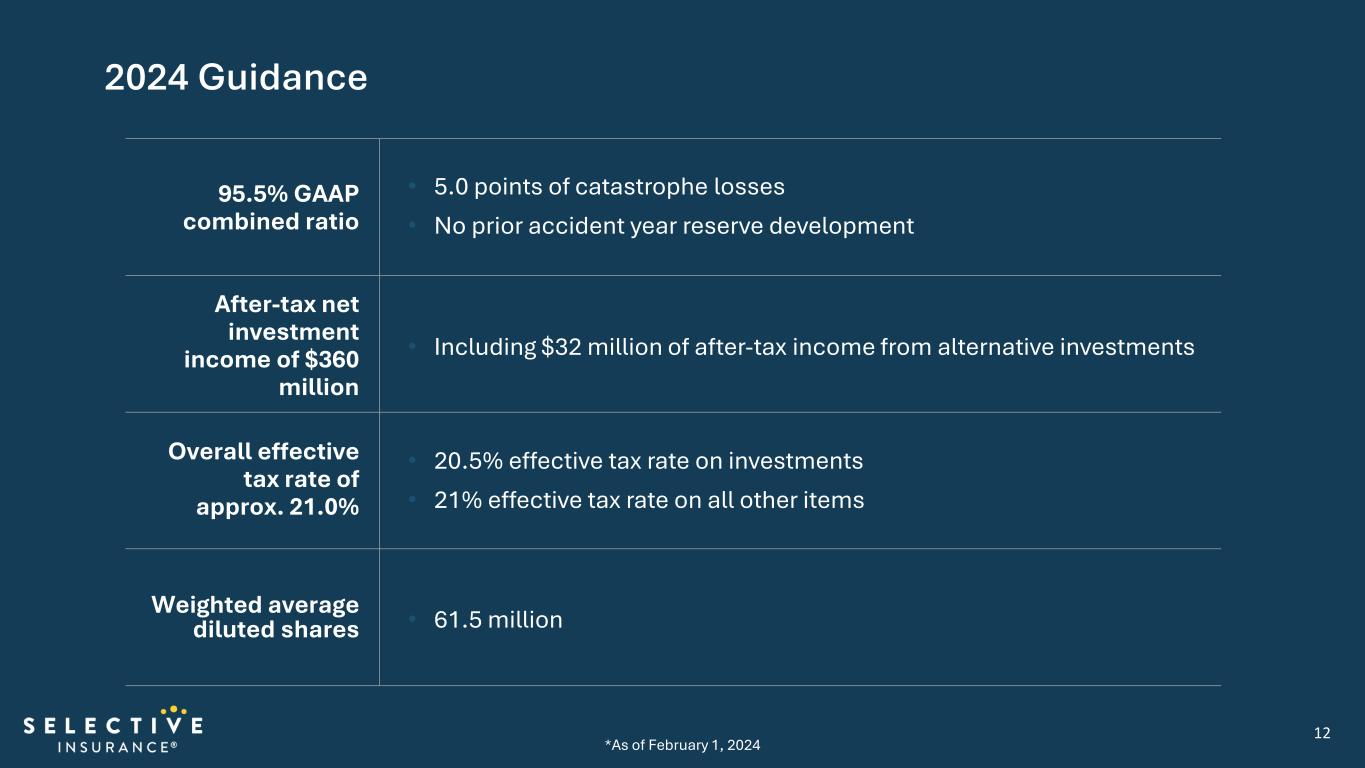

{
  "title": "2024 Guidance",
  "description": "This slide provides financial guidance for the year 2024, detailing key metrics such as GAAP combined ratio, after-tax net investment income, effective tax rates, and weighted average diluted shares.",
  "page_number": 12,
  "plots": null,
  "tables": null,
  "quotes": null,
  "others": [
    {
      "markdown": "### 2024 Guidance\n\n- **95.5% GAAP combined ratio**\n- **After-tax net investment income of $360 million**\n- **Overall effective tax rate of approx. 21.0%**\n- **Weighted average diluted shares: 61.5 million**\n- **5.0 points of catastrophe losses**\n- **No prior accident year reserve development**\n- **Including $32 million of after-tax income from alternative investments**\n- **20.5% effective tax rate on investments**\n- **21% effective tax rate on all other items**",
      "caption": null,
      "title": null
    }
  ]
}


In [13]:
url = "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve012.jpg"
vlm_visualize(url, domain="document.presentation")

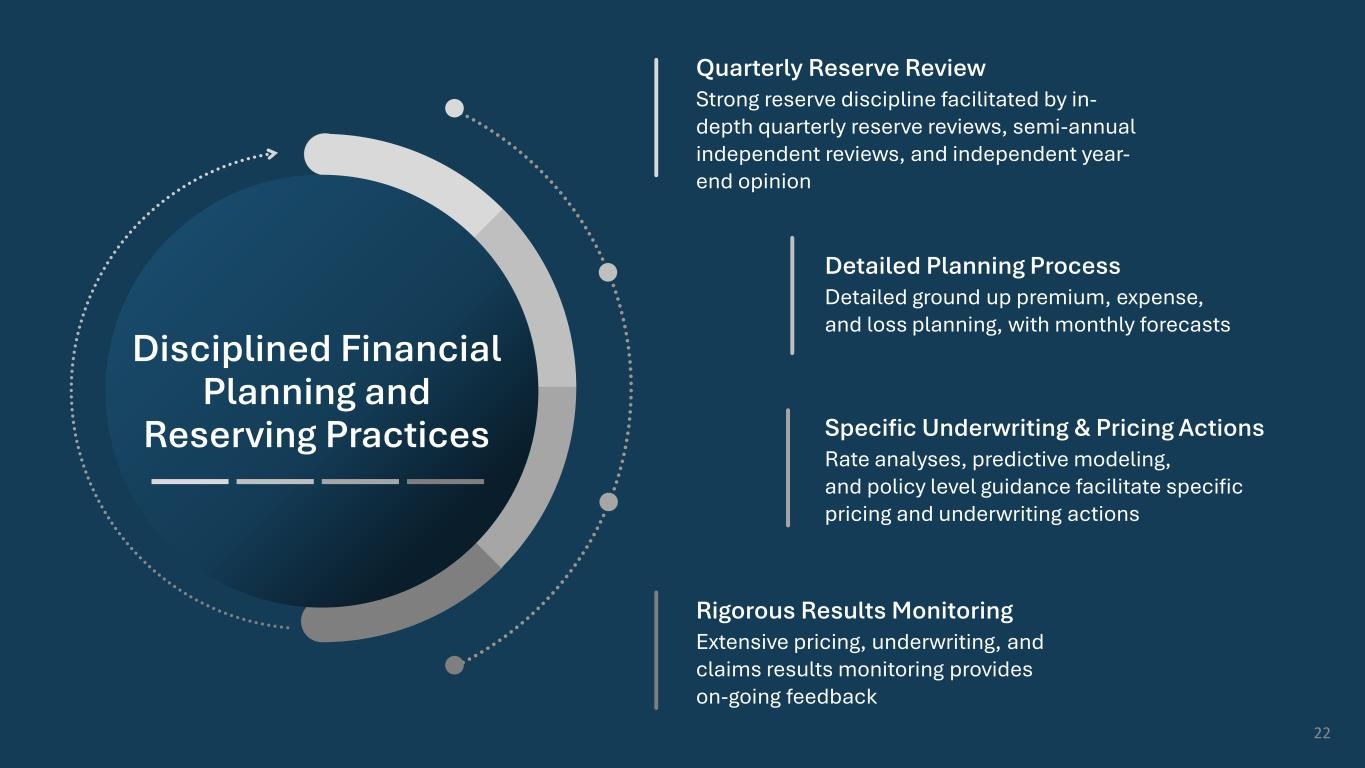

{
  "title": "Disciplined Financial Planning and Reserving Practices",
  "description": "The image presents a structured overview of disciplined financial planning and reserving practices within an organization. It highlights various aspects such as quarterly reserve review, detailed planning process, specific underwriting & pricing actions, and rigorous results monitoring.",
  "page_number": 22,
  "plots": null,
  "tables": null,
  "quotes": null,
  "others": [
    {
      "markdown": "### Disciplined Financial Planning and Reserving Practices\n\n- **Quarterly Reserve Review**\n  Strong reserve discipline facilitated by in-depth quarterly reserve reviews, semi-annual independent reviews, and independent year-end opinion.\n\n- **Detailed Planning Process**\n  Detailed ground up premium, expense, and loss planning, with monthly forecasts.\n\n- **Specific Underwriting & Pricing Actions**\n  Rate analyses, predictive modeling, and policy level guidance facilitate specific pricing and unde

In [14]:
url = "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve022.jpg"
vlm_visualize(url, domain="document.presentation")

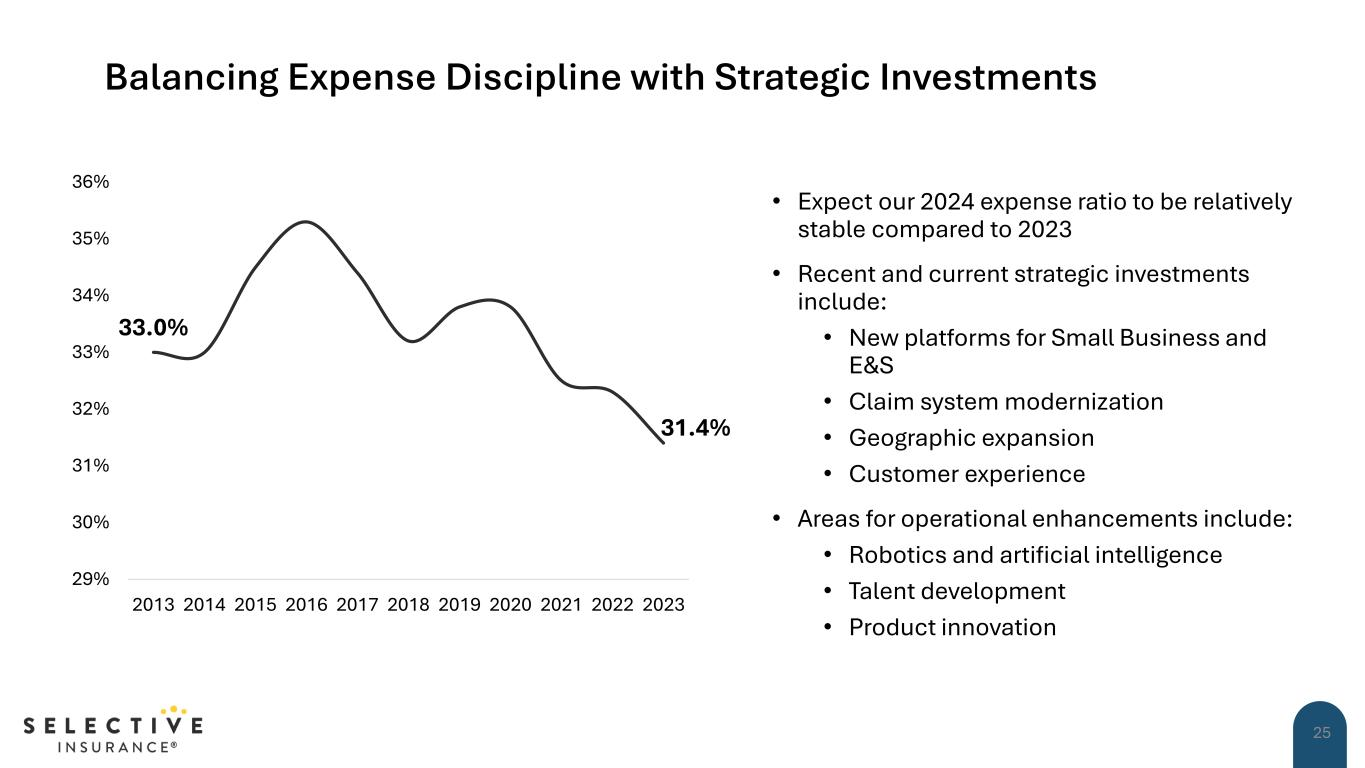

{
  "title": "Balancing Expense Discipline with Strategic Investments",
  "description": "A presentation slide from Selective Insurance showcasing a line graph and bullet points discussing strategic investments and expectations for the 2024 expense ratio.",
  "page_number": 25,
  "plots": [
    {
      "type": "line",
      "title": "Expense Ratio Trend",
      "description": "A line graph showing the expense ratio trend from 2013 to 2023, with specific data points highlighted for 2013 (33.0%) and 2023 (31.4%).",
      "markdown": "| Year | Expense Ratio |\n|------|---------------|\n| 2013 | 33.0%         |\n| 2014 | -             |\n| 2015 | -             |\n| 2016 | -             |\n| 2017 | -             |\n| 2018 | -             |\n| 2019 | -             |\n| 2020 | -             |\n| 2021 | -             |\n| 2022 | -             |\n| 2023 | 31.4%         |",
      "caption": null
    }
  ],
  "tables": null,
  "quotes": null,
  "others": [
    {
      "markdown": "### Strategic I

In [15]:
url = "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve025.jpg"
vlm_visualize(url, domain="document.presentation")

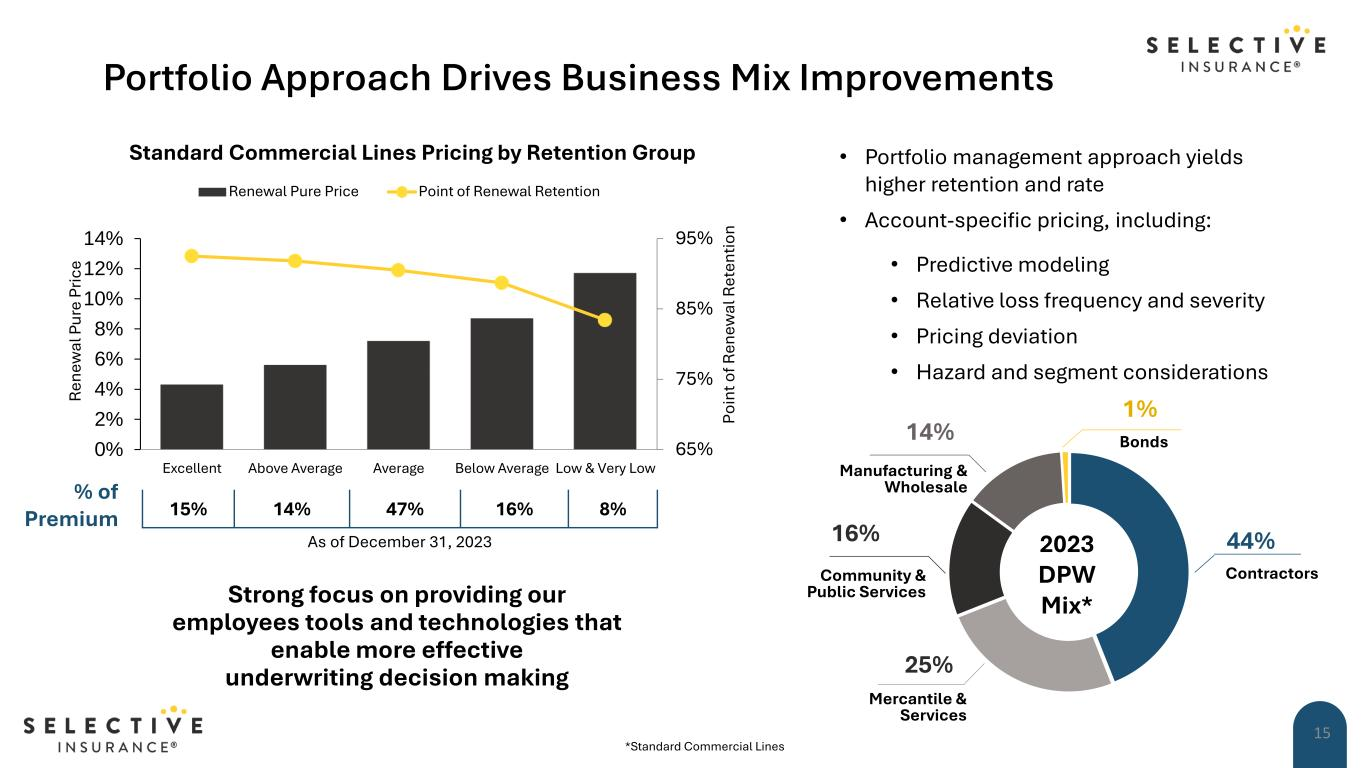

{
  "title": "Portfolio Approach Drives Business Mix Improvements",
  "description": "The image presents a slide from a presentation by Selective Insurance, detailing their portfolio approach to business mix improvements. It includes a bar graph and a pie chart, along with textual information about their pricing strategies and business segment distribution.",
  "page_number": 15,
  "plots": [
    {
      "type": "bar",
      "title": "Standard Commercial Lines Pricing by Retention Group",
      "description": "A bar graph showing the renewal pure price for different retention groups categorized as Excellent, Above Average, Average, Below Average, and Low & Very Low. It also includes a line graph overlay showing the point of renewal retention percentages for these groups.",
      "markdown": "| Retention Group | Renewal Pure Price | Point of Renewal Retention |\n|-----------------|--------------------|---------------------------|\n| Excellent       | 2%                 | 95%            

In [16]:
url = "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve015.jpg"
vlm_visualize(url, domain="document.presentation")